# Plotting precision-recall (PR) and ROC curves

## Support code

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve
from pandas.api.types import is_numeric_dtype
from matplotlib import colors
import colour

import pltvid  # pip install pltvid

Here's a method to show the decision boundary of any model that can respond to `predict_proba()` from scikit-learn:

In [5]:
def show_decision(model, df, features,
                  threshold=0.5, boundary_tolerance=.01,
                  normalize=False,
                  ax=None,
                  figsize=(4, 3),
                  legend_loc='lower right',
                  verbose=True,
                  file=None):
    if normalize:
        df = df.copy()
        df[features[0]] = (df[features[0]] - np.mean(df[features[0]])) / np.std(
            df[features[0]])
        df[features[1]] = (df[features[1]] - np.mean(df[features[1]])) / np.std(
            df[features[1]])

    X = df[features].values
    y = df['y'].values
    grid = []  # a list of coordinate pairs for the grid
    for p in np.linspace(min(X[:, 0]), max(X[:, 0]), num=100):
        for a in np.linspace(min(X[:, 1]), max(X[:, 1]), num=100):
            grid.append([p, a])
    grid = np.array(grid)
    proba = model.predict_proba(grid)[:, 1]

    if verbose:
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
        ncorrect = np.sum(y_pred == y)
        accur = ncorrect / len(y)
        prec = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        print(f"Accuracy {ncorrect}/{len(y)}={accur:.2f}")
        print(f"(threshold,precision,recall) = ({threshold:.2f},{prec:.3f},{recall:.3f})")

    grid_boundary = grid[np.isclose(proba, threshold, atol=boundary_tolerance)]

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    X0 = X[y == 0]
    X1 = X[y == 1]

    orange = colour.Color("#F46C43")
    blue = colour.Color("#4574B4")
    mycolors = np.array(list(c.hex for c in orange.range_to(blue, 100 + 1)))
    mycolors = mycolors[(proba * 100).astype(int)]
    # cmap = plt.get_cmap('coolwarm')
    # norm = colors.Normalize(np.min(proba), np.max(proba))
    ax.scatter(grid[:, 0], grid[:, 1], s=.2, c=mycolors, alpha=.3)

    ax.scatter(grid_boundary[:, 0], grid_boundary[:, 1], s=1, c='k', alpha=1)

    ax.text((max(X[:, 0]) + min(X[:, 0])) / 2,
            max(X[:, 1]),
            "$P(y=1|{\\bf x})\\geq$" + f'{threshold:.2f}',
            horizontalalignment='center')

    c0 = ax.scatter(X0[:, 0], X0[:, 1], marker='x', s=45, lw=.9, color='#F46C43', alpha=1,
                    label='class 0')
    c1 = ax.scatter(X1[:, 0], X1[:, 1], marker='o', s=45, lw=.9, color='#4574B4',
                    alpha=.75, label='class 1')

    ax.spines['top'].set_visible(False)  # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    if legend_loc is not None:
        ax.legend([c0, c1], ['class 0', 'class 1'], loc=legend_loc)
    plt.tight_layout()


## Logistic regression using toy wine data set

### Using two predictive features

In [40]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2] # Only do 2-class problem {0,1}

features = ['alcohol', 'total_phenols']
X = df_wine[features]
y = df_wine['y']

lg = LogisticRegression(solver='lbfgs')
lg.fit(X,y)

LogisticRegression()

Now, let's show the decision boundary at various thresholds, capturing each frame and saving as an animated gift (using [pltvid](https://github.com/parrt/pltvid)):

In [47]:
def capture(model, df, features, filename, steps=np.arange(0.05, 0.97)):
    camera = pltvid.Capture(dpi=200)

    p_history = []
    r_history = []
    tpr_history = []
    fpr_history = []

    # for threshold in np.append(np.arange(0.05,0.97,step=.03), [.97]*7):
    for i, threshold in enumerate(steps):
        fig, axes = plt.subplots(1, 3, figsize=(10, 3))

        show_decision(model, df, features=features,
                      threshold=threshold, boundary_tolerance=0.003,
                      ax=axes[0],
                      figsize=(5, 4),
                      verbose=False
                      )

        y_proba = lg.predict_proba(X)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
        ncorrect = np.sum(y_pred == y)
        accur = ncorrect / len(y)
        prec = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        axes[0].set_title("Logistic Regression Threshold")

        p_history.append(prec)
        r_history.append(recall)
        axes[1].plot(r_history, p_history, '-', color='k', linewidth=0.75)
        axes[1].plot(recall, prec, '.', color='red')
        align = 'right' if recall * .98 > .4 else 'left'
        axes[1].text(recall * .98, prec * .98,
                     "$P(y=1|{\\bf x})\\geq$" + f'{threshold:.2f}',
                     horizontalalignment=align, verticalalignment='top')

        axes[1].spines['top'].set_visible(False)  # turns off the top "spine" completely
        axes[1].spines['right'].set_visible(False)
        axes[1].spines['left'].set_linewidth(.5)
        axes[1].spines['bottom'].set_linewidth(.5)
        axes[1].set_xlim(0, 1.05)
        axes[1].set_ylim(-0.1, 1.05)
        axes[1].set_xlabel("Recall")
        axes[1].set_ylabel("Precision")
        axes[1].set_title("PR Curve")

        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_history.append(tpr)
        fpr_history.append(fpr)
        axes[2].plot(fpr_history, tpr_history, '-', color='k', linewidth=.75)
        axes[2].plot(fpr, tpr, '.', color='red')
        align = 'left' if fpr * 1.03 < .6 else 'right'
        axes[2].text(fpr * 1.03, tpr * .98, "$P(y=1|{\\bf x})\\geq$" + f'{threshold:.2f}',
                     horizontalalignment=align, verticalalignment='top')

        axes[2].spines['top'].set_visible(False)  # turns off the top "spine" completely
        axes[2].spines['right'].set_visible(False)
        axes[2].spines['left'].set_linewidth(.5)
        axes[2].spines['bottom'].set_linewidth(.5)
        axes[2].set_xlim(0, 1.05)
        axes[2].set_ylim(-0.1, 1.05)
        axes[2].set_xlabel("False positive rate")
        axes[2].set_ylabel("True positive rate")
        axes[2].set_title("ROC (TPR vs FPR)")

        if np.abs(threshold - 0.5) < .02:
            camera.snap(3)
        elif i == len(steps) - 1:
            camera.snap(5)
        else:
            camera.snap()

    camera.save(filename, duration=250)

In [43]:
capture(lg, df_wine, features=['alcohol', 'total_phenols'], filename="/tmp/wine.gif")

When you run that, it will save the animation in `/tmp/wine.gif`, which looks like:

<img src="wine-PR-ROC.gif" width="500">

### Using less predictive features

In [49]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2] # Only do 2-class problem {0,1}

features = ['ash', 'magnesium']
X = df_wine[features]
y = df_wine['y']

lg = LogisticRegression(solver='lbfgs')
lg.fit(X,y)

LogisticRegression()

Accuracy 92/130=0.71
(threshold,precision,recall) = (0.50,0.709,0.789)


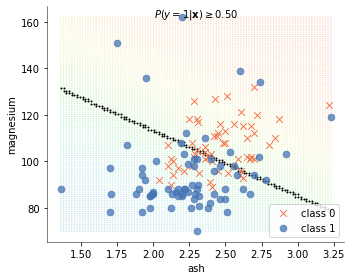

In [50]:
show_decision(lg, df_wine, features=['ash', 'magnesium'],
              threshold=0.5, boundary_tolerance=0.01, figsize=(5,4))

In [54]:
capture(lg, df_wine, features=['ash', 'magnesium'], filename="/tmp/wine2.gif",
        steps=np.arange(0.08, 0.90, step=0.03))

When you run that, it will save the animation in `/tmp/wine2.gif`, which looks like:

<img src="wine-PR-ROC2.gif" width="500">